# Multilayer Perceptron

Aiham Taleb, Benjamin Bergner, Jana Fehr

*Note: Watch the video of Prof. Lippert about this topic. And if interested, find the full notebook is in the d2l book [here](https://d2l.ai/chapter_linear-networks/softmax-regression.html).*

## From linear to nonlinear
Recall that for linear regression and softmax regression,
we mapped our inputs directly to our outputs
via a single linear transformation:

$$
\hat{\mathbf{o}} = \mathrm{softmax}(\mathbf{W} \mathbf{x} + \mathbf{b})
$$

If our labels really were related to our input data
by an approximately linear function, then this approach would be perfect.
But linearity is a *strong assumption*.
Linearity implies that for whatever target value we are trying to predict,
increasing the value of each of our inputs
should either drive the value of the output up or drive it down,
irrespective of the value of the other inputs.



In order to get a benefit from multilayer architectures,
we need another key ingredient—a nonlinearity $\sigma$ to be applied to each of the hidden units after each layer's linear transformation.
The most popular choice for the nonlinearity these days is the rectified linear unit (ReLU) $\mathrm{max}(x,0)$.
After incorporating these non-linearities
it becomes impossible to merge layers.

$$
\begin{aligned}
    \mathbf{h} & = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o})
\end{aligned}
$$

Clearly, we could continue stacking such hidden layers,
e.g. $\mathbf{h}_1 = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$
and $\mathbf{h}_2 = \sigma(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2)$
on top of each other to obtain a true multilayer perceptron.




## Concise Implementation of Multilayer Perceptron

Now that we learned how multilayer perceptrons (MLPs) work in theory, let’s implement them. We begin, as always, by
importing modules.

In [1]:
import sys
sys.path.insert(0, '..')
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


ModuleNotFoundError: No module named 'torchvision'

The only difference from our softmax regression implementation is that we add two Dense (fully-connected) layers
instead of one. The first is our hidden layer, which has 256 hidden units and uses the ReLU activation function.

In [ ]:
torch.manual_seed(119)


class Net(nn.Module):
    def __init__(self, num_inputs = 784, num_outputs = 10, num_hiddens = 256, is_training = True):
        super(Net, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        
        self.layer1 = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU())
        self.layer2 = nn.Linear(num_hiddens, num_outputs)

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1 = self.layer1(X)
        out = self.layer2(H1)        
        return out


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)        
        m.bias.data.fill_(0.01)

# Create an instance of the MLP
net = Net()
net.apply(init_weights)
print(net) 

Net(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer2): Linear(in_features=256, out_features=10, bias=True)
)


Load the Fashion MNIST Dataset.

In [ ]:
# By default pytorch torchvision datasets are of type PIL.
# Define a transform "trans" to change the PIL to Tensor format.
trans = transforms.ToTensor() 
    
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Create the Data Loaders for the training and test data

In [ ]:
batch_size = 256
if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Set the Model Configurations: Number of epochs, learning rate (lr) and the batch-size. 
Defining the Loss (criterion)

In [ ]:
num_epochs, lr = 8, 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = lr)

Training the model follows the exact same steps as in our softmax regression implementation.

In [ ]:
for epoch in range(num_epochs): 
  train_loss_epoch = 0.0
  net.train()
  for X, y in train_iter:  
    y_hat = net(X)
    l = criterion(y_hat, y)
    train_loss_epoch += l
    optimizer.zero_grad() 
    l.backward() 
    optimizer.step() 
  train_loss_epoch /= len(train_iter)
  
  net.eval()
  with torch.no_grad():
    test_loss_epoch = 0.0
    for X_test, y_test in test_iter:
      b_l = criterion(net(X_test), y_test) 
      test_loss_epoch += b_l
    test_loss_epoch /= len(test_iter)  
  print('epoch {}, train loss {}, test loss {}'.format(epoch+1, train_loss_epoch, test_loss_epoch)) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, train loss 1.041639804840088, test loss 0.6675717234611511
epoch 2, train loss 0.5982010364532471, test loss 0.5841382741928101
epoch 3, train loss 0.5181007385253906, test loss 0.5510810613632202
epoch 4, train loss 0.48116523027420044, test loss 0.5289320349693298
epoch 5, train loss 0.45358356833457947, test loss 0.4958782196044922
epoch 6, train loss 0.43440860509872437, test loss 0.4636268615722656
epoch 7, train loss 0.4173446595668793, test loss 0.44393691420555115
epoch 8, train loss 0.4041752219200134, test loss 0.4439884126186371


Visualizing the computational graph using `torchviz`

In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=57f94670751ee00b12f7fbbdd973e44e07df25f6ad0db5764c04ee4c0e561d8a
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [ ]:
from torchviz import make_dot

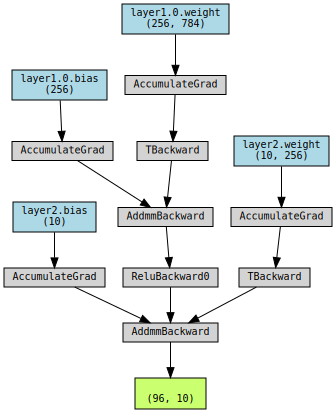

In [ ]:
make_dot(y_hat, params=dict(net.named_parameters()))

# Underfitting or Overfitting?
When we compare the training and validation errors, we want to be mindful of two common situations: First, we want to watch out for cases when our training error and validation error are both substantial but there is a little gap between them. If the model is unable to reduce the training error, that could mean that our model is too simple (i.e., insufficiently expressive) to capture the pattern that we are trying to model. Moreover, since the generalization gap between our training and validation errors is small, we have reason to believe that we could get away with a more complex model. This phenomenon is known as underfitting.

On the other hand, as we discussed above, we want to watch out for the cases when our training error is significantly lower
than our validation error, indicating severe overfitting. Note that overfitting is not always a bad thing. With deep learning
especially, it’s well known that the best predictive models often perform far better on training data than on holdout data.

Ultimately, we usually care more about the validation error than about the gap between the training and validation errors.
Whether we overfit or underfit can depend both on the complexity of our model and the size of the available training
datasets.


## Effect of model complexity
In a deep MLP, the model complexity can increase by adding more layers and neurons in those layers. Thus, allowing the model to grow larger in size, and hence in capacity. This can cause overfitting, especially on small datasets.
In order to view overfitting in practice, let's build a larger network:

In [ ]:
torch.manual_seed(119)

class LargeNet(nn.Module):
    def __init__(self, num_inputs = 784, num_outputs = 10, num_hiddens = 512, num_hiddens2 = 512, num_hiddens3 = 512, is_training = True):
        super(LargeNet, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        
        self.layer1 = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(num_hiddens, num_hiddens2),
            nn.ReLU())        
        self.layer3 = nn.Sequential(
            nn.Linear(num_hiddens2, num_hiddens3),
            nn.ReLU())     
        self.layer4 = nn.Sequential(
            nn.Linear(num_hiddens3, num_hiddens2),
            nn.ReLU())        
        self.layer4 = nn.Linear(num_hiddens3, num_outputs)

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1 = self.layer1(X)
        H2 = self.layer2(H1)        
        H3 = self.layer3(H2)
        out = self.layer4(H3)
        return out


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)        
        m.bias.data.fill_(0.01)

# Create an instance of the MLP
net = LargeNet()
net.apply(init_weights)
print(net) 

LargeNet(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer4): Linear(in_features=512, out_features=10, bias=True)
)


We will keep the same values of `epochs`, `batch_size`, and `learning rate` we used before. And will only use the new larger network instead.

In [ ]:
num_epochs, lr = 8, 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = lr)

In [ ]:
for epoch in range(num_epochs): 
  train_loss_epoch = 0.0
  net.train()
  for X, y in train_iter:  
    y_hat = net(X)
    l = criterion(y_hat, y)
    train_loss_epoch += l
    optimizer.zero_grad() 
    l.backward() 
    optimizer.step() 
  train_loss_epoch /= len(train_iter)
  
  net.eval()
  with torch.no_grad():
    test_loss_epoch = 0.0
    for X_test, y_test in test_iter:
      b_l = criterion(net(X_test), y_test) 
      test_loss_epoch += b_l
    test_loss_epoch /= len(test_iter)  
  print('epoch {}, train loss {}, test loss {}'.format(epoch+1, train_loss_epoch, test_loss_epoch)) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, train loss 2.162475109100342, test loss 1.393125295639038
epoch 2, train loss 1.1452317237854004, test loss 1.006527066230774
epoch 3, train loss 0.8388906717300415, test loss 0.7419486045837402
epoch 4, train loss 0.6675246953964233, test loss 0.7109178900718689
epoch 5, train loss 0.5705137848854065, test loss 0.5447368025779724
epoch 6, train loss 0.5072546601295471, test loss 0.5739651918411255
epoch 7, train loss 0.47151821851730347, test loss 0.6394158601760864
epoch 8, train loss 0.43845078349113464, test loss 0.5693482756614685


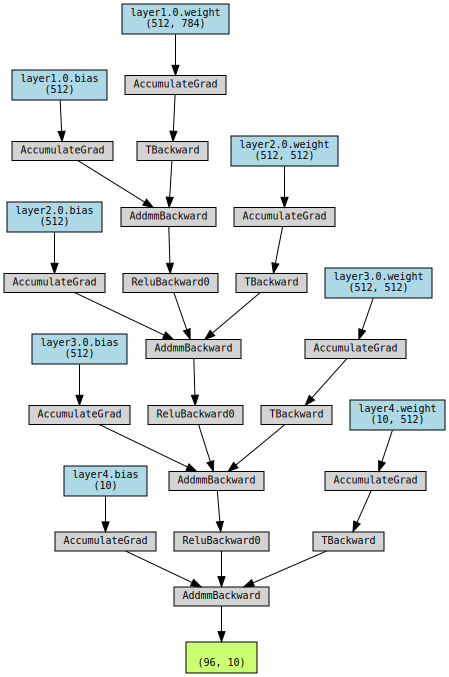

In [ ]:
make_dot(y_hat, params=dict(net.named_parameters()))

## Weight decay
Weight decay (commonly called *L2* regularization), might be the most widely-used technique for regularizing parametric machine learning models.
Because weight decay is ubiquitous in neural network optimization,
Pytorch makes it especially convenient, integrating weight decay into the optimization algorithm itself for easy use in combination with any loss function.

In the following code, we specify the weight decay hyper-parameter directly through the `weight_decay` parameter when instantiating our `Optimizer`. By default, Pytorch decays both weights and biases simultaneously.


In [ ]:
# Re-create an instance of the MLP (in order to init the weights again)
net = LargeNet()
net.apply(init_weights)

# note the weight_decay param
optimizer = torch.optim.SGD(net.parameters(), lr = lr, weight_decay=1e-2)

In [ ]:
for epoch in range(num_epochs): 
  train_loss_epoch = 0.0
  net.train()
  for X, y in train_iter:  
    y_hat = net(X)
    l = criterion(y_hat, y)
    train_loss_epoch += l
    optimizer.zero_grad() 
    l.backward() 
    optimizer.step() 
  train_loss_epoch /= len(train_iter)
  
  net.eval()
  with torch.no_grad():
    test_loss_epoch = 0.0
    for X_test, y_test in test_iter:
      b_l = criterion(net(X_test), y_test) 
      test_loss_epoch += b_l
    test_loss_epoch /= len(test_iter)  
  print('epoch {}, train loss {}, test loss {}'.format(epoch+1, train_loss_epoch, test_loss_epoch)) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, train loss 2.241260051727295, test loss 1.7249702215194702
epoch 2, train loss 1.3154863119125366, test loss 1.2454272508621216
epoch 3, train loss 1.0288447141647339, test loss 1.2049229145050049
epoch 4, train loss 0.898503303527832, test loss 0.9101511836051941
epoch 5, train loss 0.790444552898407, test loss 0.89070063829422
epoch 6, train loss 0.7518267035484314, test loss 0.77562415599823
epoch 7, train loss 0.7061833739280701, test loss 0.7294523119926453
epoch 8, train loss 0.6774700880050659, test loss 0.6935403943061829
